# ARTIFICIAL NEURAL NETWORK

An artificial neural network (ANN) is a machine learning model that mimics the human brain to process data. It's made up of interconnected nodes, or artificial neurons, that work together to solve complex problems. Artificial Neural Networks contain artificial neurons which are called units . These units are arranged in a series of layers that together constitute the whole Artificial Neural Network in a system. Artificial Neural Network has an input layer, an output layer as well as hidden layers. The input layer receives data from the outside world which the neural network needs to analyze or learn about. Then this data passes through one or multiple hidden layers that transform the input into data that is valuable for the output layer. Finally, the output layer provides an output in the form of a response of the Artificial Neural Networks to input data provided.

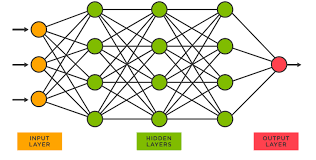
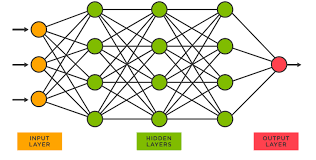

# IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score

# LOAD DATASET

In [2]:
# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# DATA PREPROCESSING

In [3]:
# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])
# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target (No Feature Selection)
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# TRAIN & TEST SPLIT

In [4]:
# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


# BUILDING ANN MODEL BEFORE FEATURE SELECTION

In [5]:
# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# TRAINING ANN MODEL BEFORE FEATURE SELECTION

In [6]:
# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

Epoch 1/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7734 - loss: 0.4715 - val_accuracy: 0.8074 - val_loss: 0.4191
Epoch 2/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8004 - loss: 0.4282 - val_accuracy: 0.8132 - val_loss: 0.4078
Epoch 3/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8048 - loss: 0.4203 - val_accuracy: 0.8153 - val_loss: 0.4016
Epoch 4/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8100 - loss: 0.4117 - val_accuracy: 0.8164 - val_loss: 0.3993
Epoch 5/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8130 - loss: 0.4071 - val_accuracy: 0.8205 - val_loss: 0.3935
Epoch 6/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8154 - loss: 0.4013 - val_accuracy: 0.8238 - val_loss: 0.3875
Epoch 7/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8181 - loss: 0.3970 - val_accuracy: 0.8243 - val_loss: 0.3861
Epoch 8/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8228 - loss: 

# EVALUATING ANN MODEL BEFORE FEATURE SELECTION

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


🔹 Accuracy: 0.9039
🔹 Precision: 0.8844
🔹 Recall: 0.9293
🔹 F1-Score: 0.9063
🔹 G-Mean: 0.9036
🔹 ROC AUC: 0.9599
🔹 Optimal Threshold: 0.58
🔹 Confusion Matrix:
[[19485  2695]
 [ 1567 20612]]


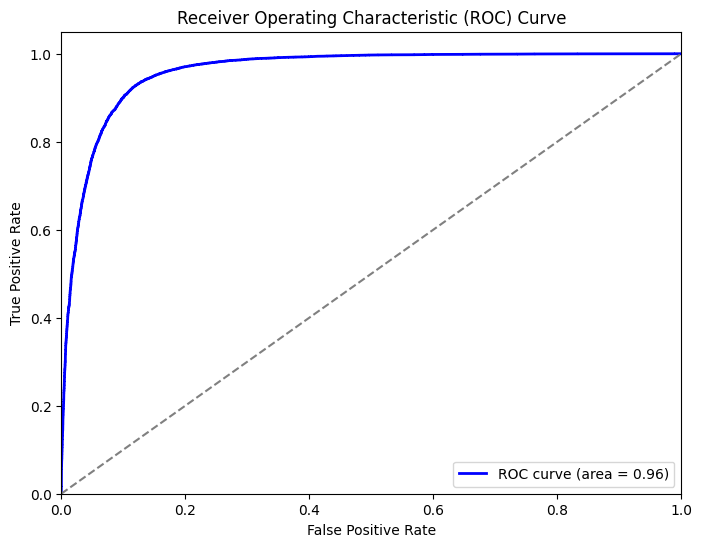

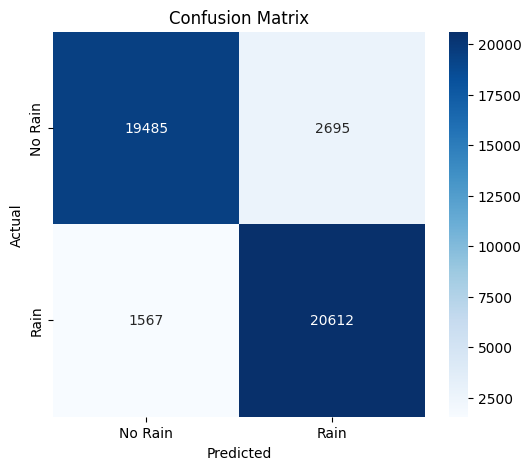

In [7]:
# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# AFTER FEATURE SELECTION

# IMPORTING LIBRARIES

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# LOADING DATASET

In [9]:
# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# DATA PREPROCESSING & FEATURE SELECTION

In [10]:
# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Ensure all values are non-negative for feature selection
X_shifted = X - X.min().min()

# ✅ Feature Selection Using Mutual Information
k_best = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_selected = k_best.fit_transform(X_shifted, y)  # Apply BEFORE standardization

# ✅ Normalize Features **After** Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# TRAIN & TEST SPLIT

In [11]:
# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


#  BUILDING ANN MODEL

In [12]:
# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# TRAINING ANN MODEL AFTER FEATURE SELECTION

In [13]:
# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

Epoch 1/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7759 - loss: 0.4674 - val_accuracy: 0.8022 - val_loss: 0.4221
Epoch 2/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7970 - loss: 0.4323 - val_accuracy: 0.8092 - val_loss: 0.4122
Epoch 3/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8035 - loss: 0.4218 - val_accuracy: 0.8123 - val_loss: 0.4061
Epoch 4/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8088 - loss: 0.4133 - val_accuracy: 0.8131 - val_loss: 0.4026
Epoch 5/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8101 - loss: 0.4102 - val_accuracy: 0.8159 - val_loss: 0.4006
Epoch 6/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8144 - loss: 0.4023 - val_accuracy: 0.8192 - val_loss: 0.3948
Epoch 7/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8179 - loss: 0.3969 - val_accuracy: 0.8206 - val_loss: 0.3894
Epoch 8/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8196 - loss: 

# EVALUATING ANN MODEL AFTER FEATURE SELECTION

🔹 Accuracy: 0.9122
🔹 Precision: 0.9053
🔹 Recall: 0.9207
🔹 F1-Score: 0.9130
🔹 G-Mean: 0.9122
🔹 ROC AUC: 0.9640
🔹 Optimal Threshold: 0.72
🔹 Confusion Matrix:
[[20044  2136]
 [ 1758 20422]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


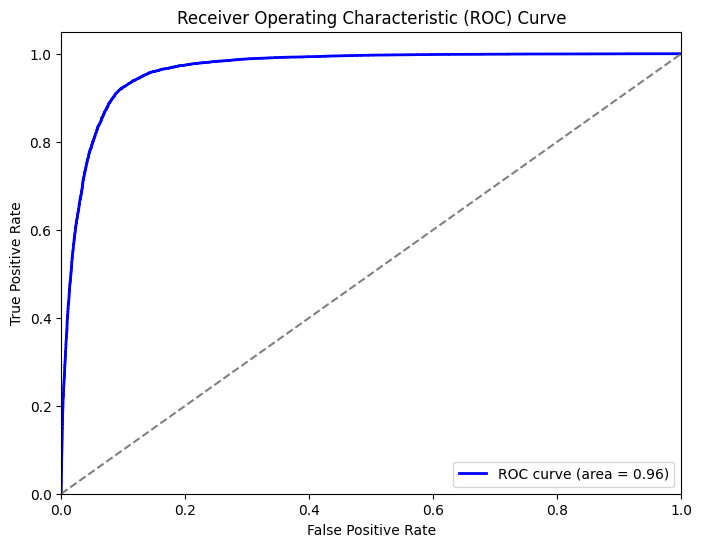

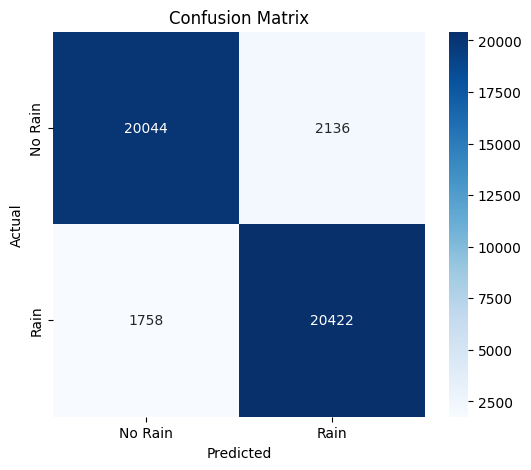

In [14]:
# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Ensure all values are non-negative for feature selection
X_shifted = X - X.min().min()

# ✅ Feature Selection Using Mutual Information
k_best = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_selected = k_best.fit_transform(X_shifted, y)  # Apply BEFORE standardization

# ✅ Normalize Features **After** Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns  # Numeric columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')  # Convert invalid values to NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
df[num_features] = df[num_features].clip(-1e6, 1e6)  # Clip extreme values

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")  # Mean for numeric columns
cat_imputer = SimpleImputer(strategy="most_frequent")  # Mode for categorical columns
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])  # Adjust target column as needed
y = df["RainTomorrow"]

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define ANN Model with Early Stopping
def build_ann(learning_rate=0.0003, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0003, dropout_rate=0.2)
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Recall & F1-Score
y_pred_proba = model.predict(X_test)
threshold = 0.4  # Adjusting threshold to improve recall
y_pred = (y_pred_proba > threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")


Epoch 1/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.7868 - loss: 0.4543 - val_accuracy: 0.8041 - val_loss: 0.4188
Epoch 2/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.8064 - loss: 0.4181 - val_accuracy: 0.8108 - val_loss: 0.4067
Epoch 3/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.8141 - loss: 0.4045 - val_accuracy: 0.8169 - val_loss: 0.3940
Epoch 4/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.8185 - loss: 0.3957 - val_accuracy: 0.8203 - val_loss: 0.3874
Epoch 5/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.8248 - loss: 0.3847 - val_accuracy: 0.8270 - val_loss: 0.3778
Epoch 6/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.8300 - loss: 0.3749 - val_accuracy: 0.8336 - val_loss: 0.3688
Epoch 7/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.8388 - loss: 0.3596 - val_accuracy: 0.8373 - val_loss: 0.3660
Epoch 8/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7858 - loss: 0.4565 - val_accuracy: 0.8040 - val_loss: 0.4221
Epoch 2/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8058 - loss: 0.4217 - val_accuracy: 0.8132 - val_loss: 0.4053
Epoch 3/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8128 - loss: 0.4059 - val_accuracy: 0.8185 - val_loss: 0.3962
Epoch 4/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8198 - loss: 0.3945 - val_accuracy: 0.8230 - val_loss: 0.3883
Epoch 5/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8243 - loss: 0.3851 - val_accuracy: 0.8290 - val_loss: 0.3782
Epoch 6/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8319 - loss: 0.3735 - val_accuracy: 0.8306 - val_loss: 0.3714
Epoch 7/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8363 - loss: 0.3645 - val_accuracy: 0.8367 - val_loss: 0.3658
Epoch 8/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8432 - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


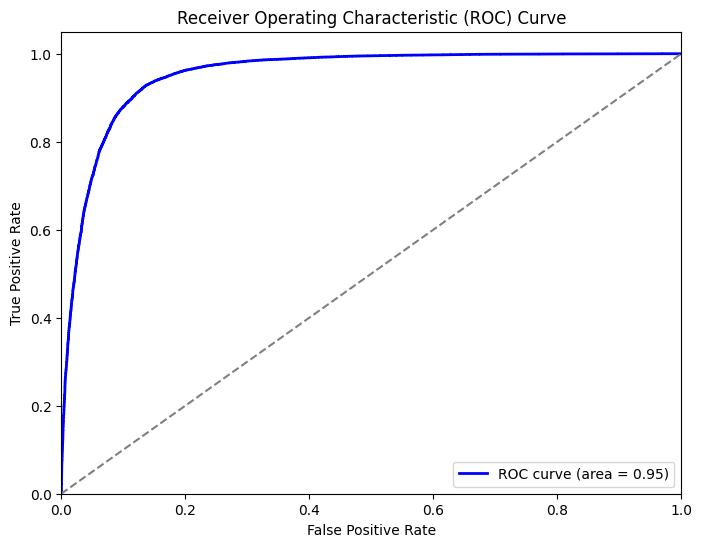

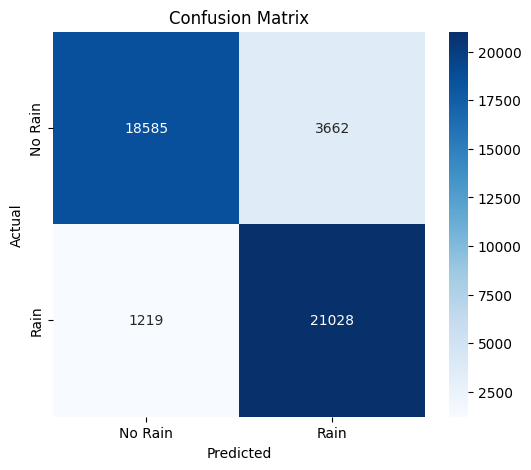

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns  # Numeric columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')  # Convert invalid values to NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
df[num_features] = df[num_features].clip(-1e6, 1e6)  # Clip extreme values

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")  # Mean for numeric columns
cat_imputer = SimpleImputer(strategy="most_frequent")  # Mode for categorical columns
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])  # Adjust target column as needed
y = df["RainTomorrow"]

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define ANN Model with Early Stopping
def build_ann(learning_rate=0.0003, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0003, dropout_rate=0.2)
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Recall & F1-Score
y_pred_proba = model.predict(X_test)
threshold = 0.4  # Adjusting threshold to improve recall
y_pred = (y_pred_proba > threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7749 - loss: 0.4683 - val_accuracy: 0.8081 - val_loss: 0.4154
Epoch 2/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7989 - loss: 0.4298 - val_accuracy: 0.8124 - val_loss: 0.4068
Epoch 3/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8058 - loss: 0.4185 - val_accuracy: 0.8169 - val_loss: 0.3992
Epoch 4/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8101 - loss: 0.4112 - val_accuracy: 0.8193 - val_loss: 0.3938
Epoch 5/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8141 - loss: 0.4053 - val_accuracy: 0.8198 - val_loss: 0.3918
Epoch 6/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8158 - loss: 0.4025 - val_accuracy: 0.8241 - val_loss: 0.3878
Epoch 7/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8190 - loss: 0.3934 - val_accuracy: 0.8260 - val_loss: 0.3818
Epoch 8/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8222 - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


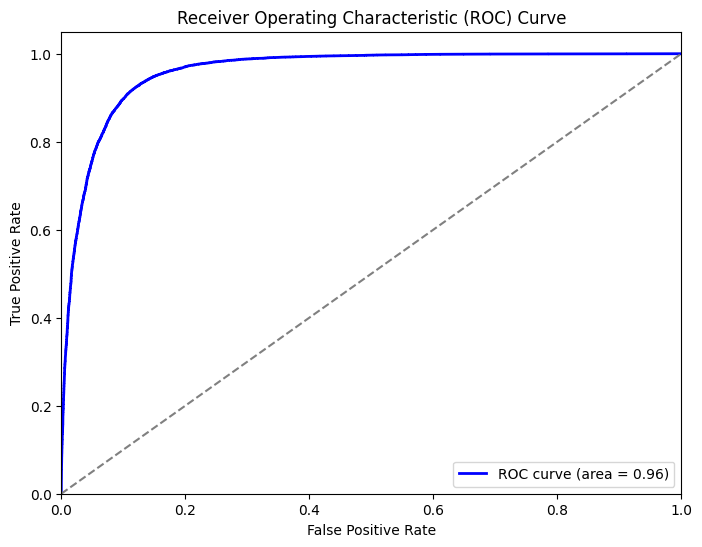

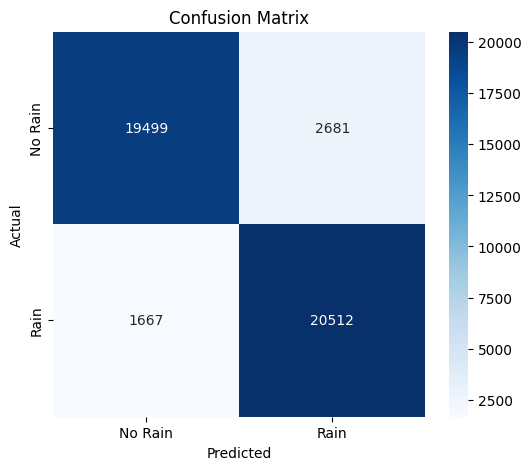

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target (No Feature Selection)
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Selected Features: Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')
Epoch 1/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7757 - loss: 0.4726 - val_accuracy: 0.7997 - val_loss: 0.4287
Epoch 2/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7958 - loss: 0.4353 - val_accuracy: 0.8027 - val_loss: 0.4210
Epoch 3/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8018 - loss: 0.4261 - val_accuracy: 0.8084 - val_loss: 0.4133
Epoch 4/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8053 - loss: 0.4197 - val_accuracy: 0.8092 - val_loss: 0.4111
Epoch 5/100
2781/2781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8087 - loss: 0.4151 - val_accuracy: 0.8147 - val_loss: 0.4025
Epoch 6/1

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


🔹 Accuracy: 0.8748
🔹 Precision: 0.8386
🔹 Recall: 0.9282
🔹 F1-Score: 0.8811
🔹 G-Mean: 0.8731
🔹 ROC AUC: 0.9436
🔹 Confusion Matrix:
[[18273  3974]
 [ 1598 20649]]


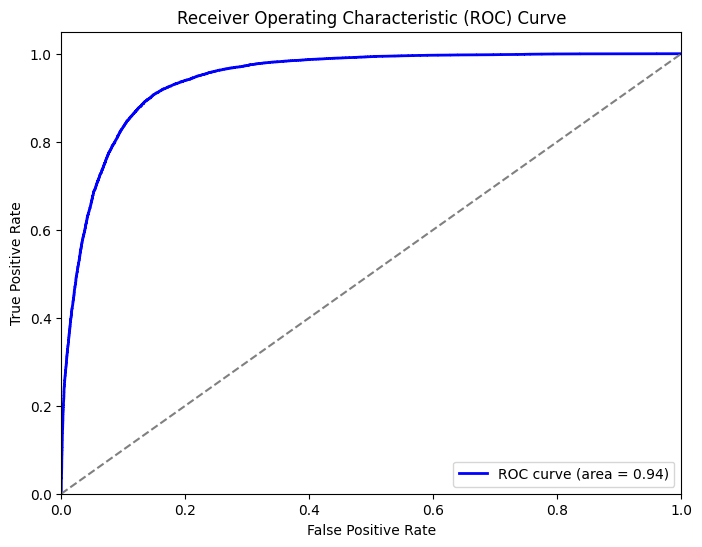

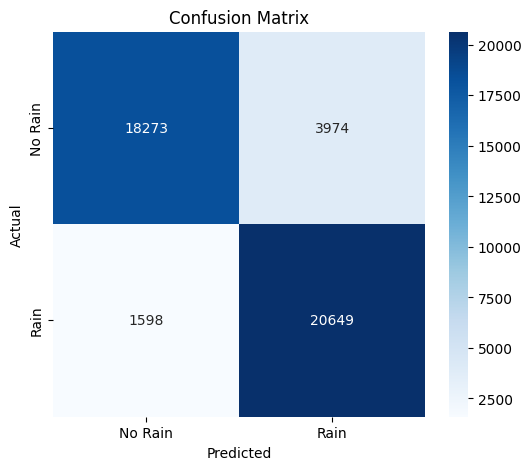

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns  # Numeric columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')  # Convert invalid values to NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
df[num_features] = df[num_features].clip(-1e6, 1e6)  # Clip extreme values

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")  # Mean for numeric columns
cat_imputer = SimpleImputer(strategy="most_frequent")  # Mode for categorical columns
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])  # Adjust target column as needed
y = df["RainTomorrow"]

# ✅ Feature Selection with Mutual Information
k = 20  # Select top 20 best features
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

# ✅ Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected Features: {selected_features}")

# ✅ Normalize Features
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.3)
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Recall & F1-Score
y_pred_proba = model.predict(X_test)
threshold = 0.45  # Adjusted threshold
y_pred = (y_pred_proba > threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7752 - loss: 0.4701 - val_accuracy: 0.8029 - val_loss: 0.4218
Epoch 2/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8003 - loss: 0.4306 - val_accuracy: 0.8081 - val_loss: 0.4116
Epoch 3/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8041 - loss: 0.4223 - val_accuracy: 0.8116 - val_loss: 0.4072
Epoch 4/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8076 - loss: 0.4167 - val_accuracy: 0.8171 - val_loss: 0.4005
Epoch 5/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8099 - loss: 0.4110 - val_accuracy: 0.8194 - val_loss: 0.3972
Epoch 6/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8148 - loss: 0.4030 - val_accuracy: 0.8201 - val_loss: 0.3944
Epoch 7/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8155 - loss: 0.4006 - val_accuracy: 0.8221 - val_loss: 0.3884
Epoch 8/150
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8190 - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


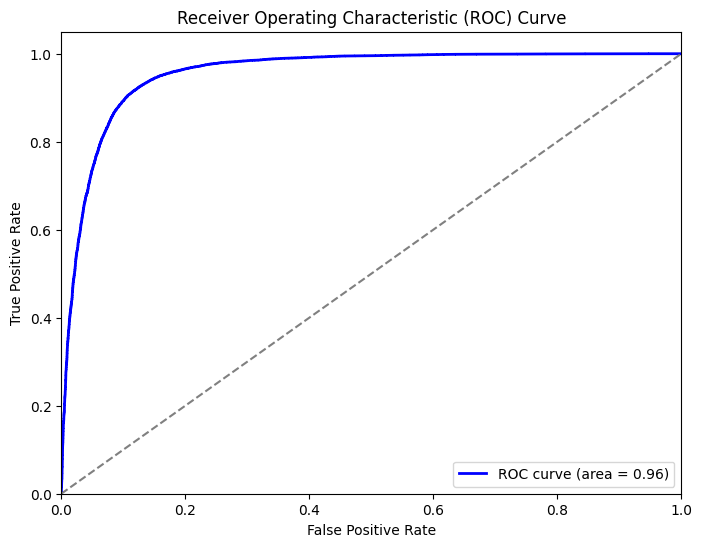

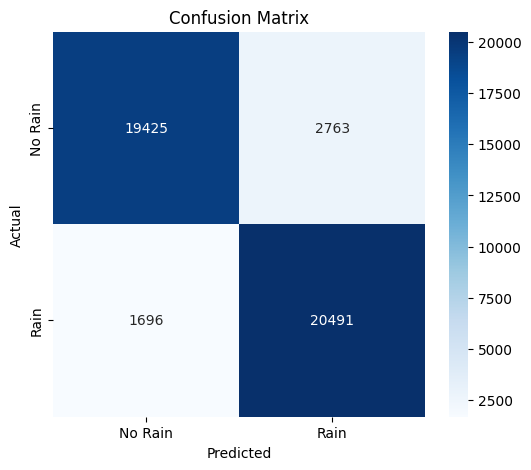

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, chi2

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Ensure all values are non-negative for chi2
X_shifted = X - X.min().min()

# ✅ Feature Selection Using SelectKBest (Chi-Square)
k_best = SelectKBest(score_func=chi2, k=20)  # Selects top 20 features
X_selected = k_best.fit_transform(X_shifted, y)  # Apply BEFORE standardization


# ✅ Normalize Features **After** Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, chi2

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Ensure all values are non-negative for chi2
X_shifted = X - X.min().min()

# ✅ Feature Selection Using SelectKBest (Chi-Square)
k_best = SelectKBest(score_func=chi2, k=15)  # Selects top 20 features
X_selected = k_best.fit_transform(X_shifted, y)  # Apply BEFORE standardization


# ✅ Normalize Features **After** Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7639 - loss: 0.4847 - val_accuracy: 0.7869 - val_loss: 0.4498
Epoch 2/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7862 - loss: 0.4530 - val_accuracy: 0.7899 - val_loss: 0.4444
Epoch 3/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7877 - loss: 0.4510 - val_accuracy: 0.7933 - val_loss: 0.4381
Epoch 4/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7923 - loss: 0.4430 - val_accuracy: 0.7951 - val_loss: 0.4337
Epoch 5/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7954 - loss: 0.4364 - val_accuracy: 0.8006 - val_loss: 0.4298
Epoch 6/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7957 - loss: 0.4353 - val_accuracy: 0.8017 - val_loss: 0.4278
Epoch 7/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8003 - loss: 0.4298 - val_accuracy: 0.8027 - val_loss: 0.4263
Epoch 8/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8022 - loss: 

Epoch 1/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7709 - loss: 0.4720 - val_accuracy: 0.8021 - val_loss: 0.4231
Epoch 2/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7990 - loss: 0.4306 - val_accuracy: 0.8079 - val_loss: 0.4127
Epoch 3/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8047 - loss: 0.4220 - val_accuracy: 0.8122 - val_loss: 0.4084
Epoch 4/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8087 - loss: 0.4127 - val_accuracy: 0.8150 - val_loss: 0.4017
Epoch 5/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8128 - loss: 0.4061 - val_accuracy: 0.8152 - val_loss: 0.3979
Epoch 6/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8161 - loss: 0.4008 - val_accuracy: 0.8181 - val_loss: 0.3951
Epoch 7/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8185 - loss: 0.3951 - val_accuracy: 0.8223 - val_loss: 0.3872
Epoch 8/150
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8186 - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


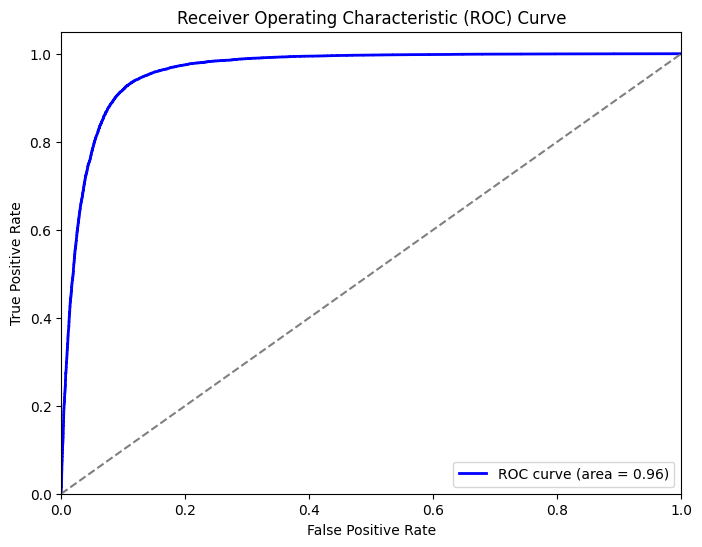

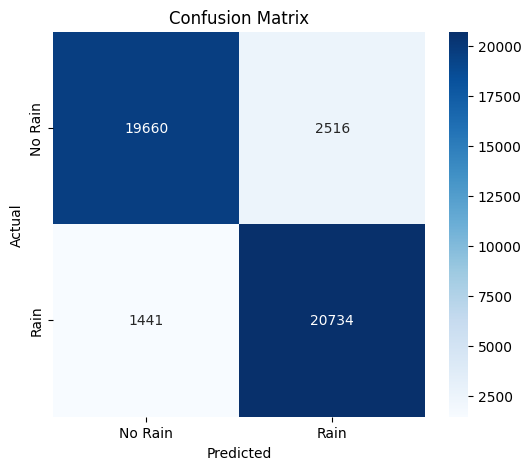

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# ✅ Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
df = pd.read_csv(file_path)

# ✅ Drop rows with too many missing values
df.dropna(thresh=int(0.6 * df.shape[1]), inplace=True)

# ✅ Fix Inf & Large Values
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = df[num_features].apply(pd.to_numeric, errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_features] = df[num_features].clip(-1e6, 1e6)

# ✅ Handle Missing Values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_features = df.select_dtypes(include=["object"]).columns

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# ✅ Encode Categorical Features
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ✅ Define Features & Target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# ✅ Ensure all values are non-negative for feature selection
X_shifted = X - X.min().min()

# ✅ Feature Selection Using Mutual Information
k_best = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_selected = k_best.fit_transform(X_shifted, y)  # Apply BEFORE standardization

# ✅ Normalize Features **After** Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# ✅ Handle Class Imbalance Using SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_scaled, y)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Define Optimized ANN Model
def build_ann(learning_rate=0.0002, dropout_rate=0.4):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# ✅ Train Model with Early Stopping
model = build_ann(learning_rate=0.0002, dropout_rate=0.4)
history = model.fit(X_train, y_train, 
                    epochs=150, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Tune Threshold to Improve Accuracy & Recall
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba > optimal_threshold).astype(int)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ ROC Curve
roc_auc = auc(fpr, tpr)

# ✅ Display Results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 G-Mean: {g_mean:.4f}")
print(f"🔹 ROC AUC: {roc_auc:.4f}")
print(f"🔹 Optimal Threshold: {optimal_threshold:.2f}")
print(f"🔹 Confusion Matrix:\n{conf_matrix}")

# ✅ Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
